In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from numba import jit

visual_drift_coef = 1
memory_drift_coef = 2/3
memory_drift_adaptive_coef = 1/2

I can add visual delay later to account for bigger RT at the beginning

Important: Check for memory drift adding after a press or after the visual delay for the next press

In [2]:
%load_ext line_profiler

In [3]:
def calc_visual_drifts(seq, seq_length):
    seq_fingers = np.array([int(_) for _ in seq]) - 1
    result = np.zeros((5, seq_length))

    result[seq_fingers, np.arange(seq_length)] = visual_drift_coef


    return result



In [4]:
def calc_memory_drifts(specific_seq, seq_length):
    seq_fingers = np.array([int(_) for _ in specific_seq]) - 1
    result = np.zeros((5, seq_length))

    result[seq_fingers, np.arange(seq_length)] = 1


    return result

In [5]:
seq = '13524232514'
specific_seq = '13524232514'
specific_seq_changed = '13524313333'
specific_seq_changed_one_digit = '13524212514'
random_seq = '45341323141'



seq_length = len(seq)

window_sizes = [1,2,3,4,11]

visual_drifts = calc_visual_drifts(seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)

# drifts = np.array([1,1,1,1,2]).reshape(5, 1)
# drifts = np.repeat(drifts, seq_length , axis = 1)

visual_delay = 100

diffusion = 5
threshold = 600


In [6]:
visual_drifts

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.]])

In [7]:
memory_drifts

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.]])

In [8]:
a = [1,2,3]
a[:-1]

[1, 2]

In [9]:
@jit(nopython=True)
def get_planning_coefs(strategy, capacity, param):
    if strategy == 0:
        return exp_normalized_planning_jit(capacity, param)
    elif strategy == 1:
        return inv_normalized_planning_jit(capacity)
    else:
        raise ValueError("Unknown strategy")

@jit(nopython=True)
def exp_normalized_planning_jit(capacity, param):
    x = np.arange(1, capacity + 1)
    if capacity == 0:
        theta = np.exp(-x * np.log(param))
    if capacity == 1:
        theta = np.exp(-x * np.log(param))
    if capacity == 2:
        theta = np.exp(-x * np.log(2.3))
    
    if capacity == 3:
        theta = np.exp(-x * np.log(2.4))

    if capacity >= 4: 
        theta = np.exp(-x * np.log(2.45))

    # theta /= np.sum(theta)
    
    return theta * 4

@jit(nopython=True)
def inv_normalized_planning_jit(capacity):
    x = np.arange(capacity)
    theta = 1 / (x + 1)
    # theta /= np.sum(theta)
    return theta

In [10]:
for i in range(4):
    print(exp_normalized_planning_jit(capacity=i , param = 2) * 4)
    print(sum(exp_normalized_planning_jit(capacity=i , param = 2)) * 4)


[]
0
[8.]
8.0
[6.95652174 3.02457467]
9.981096408317581
[6.66666667 2.77777778 1.15740741]
10.601851851851853


In [11]:
for i in range(4):
    print(exp_normalized_planning_jit(capacity=i , param = 2.3) * 4)
    print(sum(exp_normalized_planning_jit(capacity=i , param = 2.3)) * 4)

[]
0
[6.95652174]
6.9565217391304355
[6.95652174 3.02457467]
9.981096408317581
[6.66666667 2.77777778 1.15740741]
10.601851851851853


In [12]:
for i in range(11):
    print(exp_normalized_planning_jit(capacity=i , param = 2.4) * 4)
    print(sum(exp_normalized_planning_jit(capacity=i , param = 2.4)) * 4)


[]
0
[6.66666667]
6.666666666666667
[6.95652174 3.02457467]
9.981096408317581
[6.66666667 2.77777778 1.15740741]
10.601851851851853
[6.53061224 2.66555602 1.08798205 0.44407431]
10.728224616946878
[6.53061224 2.66555602 1.08798205 0.44407431 0.18125482]
10.90947943548852
[6.53061224 2.66555602 1.08798205 0.44407431 0.18125482 0.07398156]
10.983460994076944
[6.53061224 2.66555602 1.08798205 0.44407431 0.18125482 0.07398156
 0.03019655]
11.013657548602833
[6.53061224 2.66555602 1.08798205 0.44407431 0.18125482 0.07398156
 0.03019655 0.01232512]
11.025982672899113
[6.53061224e+00 2.66555602e+00 1.08798205e+00 4.44074305e-01
 1.81254819e-01 7.39815586e-02 3.01965545e-02 1.23251243e-02
 5.03066298e-03]
11.031013335877187
[6.53061224e+00 2.66555602e+00 1.08798205e+00 4.44074305e-01
 1.81254819e-01 7.39815586e-02 3.01965545e-02 1.23251243e-02
 5.03066298e-03 2.05333183e-03]
11.033066667704972


In [13]:
for i in range(11):
    print(exp_normalized_planning_jit(capacity=i , param = 2.45) * 4)
    print(sum(exp_normalized_planning_jit(capacity=i , param = 2.45)) * 4)


[]
0
[6.53061224]
6.530612244897958
[6.95652174 3.02457467]
9.981096408317581
[6.66666667 2.77777778 1.15740741]
10.601851851851853
[6.53061224 2.66555602 1.08798205 0.44407431]
10.728224616946878
[6.53061224 2.66555602 1.08798205 0.44407431 0.18125482]
10.90947943548852
[6.53061224 2.66555602 1.08798205 0.44407431 0.18125482 0.07398156]
10.983460994076944
[6.53061224 2.66555602 1.08798205 0.44407431 0.18125482 0.07398156
 0.03019655]
11.013657548602833
[6.53061224 2.66555602 1.08798205 0.44407431 0.18125482 0.07398156
 0.03019655 0.01232512]
11.025982672899113
[6.53061224e+00 2.66555602e+00 1.08798205e+00 4.44074305e-01
 1.81254819e-01 7.39815586e-02 3.01965545e-02 1.23251243e-02
 5.03066298e-03]
11.031013335877187
[6.53061224e+00 2.66555602e+00 1.08798205e+00 4.44074305e-01
 1.81254819e-01 7.39815586e-02 3.01965545e-02 1.23251243e-02
 5.03066298e-03 2.05333183e-03]
11.033066667704972


In [14]:
def exp_normalized_planning(capacity=3, param = 3):
    """
    Exponential decay function for planning

    args: 
        capacity (int): capacity of planning
        param (list/np.array): rate
    """
    x = np.arange(capacity)
    theta = np.exp(-x * np.log(param))
    # theta /= sum(theta)

    return theta


def inv_normalized_planning(capacity=3):
    x = np.arange(capacity)
    theta = 1/(x+1)
    # theta /= sum(theta)

    return theta

In [15]:
def check_evidence_to_seq(evidence, seq):
    for press in range(len(seq)):
        if ~(np.argmax(evidence[:, press]) + 1 == int(seq[press])):
            return False
    return True

In [16]:
def calculate_IPI_from_press_time(press_times):

   return [press_times[0]] + [press_times[i] - press_times[i-1] for i in range(1, len(press_times))]

In [17]:
@jit(nopython=True)
def simulate_ddm(seq, specific_seq, visual_drifts, memory_drifts, diffusion, threshold, dt, max_time, 
                 seq_length, window_size, planning_capacity, planning_param, planning_strategy, visual_delay):
    evidence = np.zeros((5, seq_length))
    time = 0
    visual_delay_queue = np.zeros(min(window_size, seq_length, planning_capacity))
    current_press = 0
    current_memory_coef = 0
    effective_planning_capacity = 0
    visible_window_size = 0

    planning_coefs = get_planning_coefs(planning_strategy, effective_planning_capacity, planning_param)


    sqrt_dt = np.sqrt(dt)
    drifts_visual_dt = visual_drifts * dt
    drifts_memory_dt = memory_drifts * dt
    diffusion_term = diffusion * sqrt_dt

    total_steps = int(max_time / dt)
    random_terms = np.random.randn(5, total_steps)
    random_terms_memory = np.random.rand(5, total_steps)

    t_index = 0

    press_times = np.full(seq_length, np.nan)

    while time < max_time:
        time += dt
        visual_delay_queue += dt
        t_index += 1

        for press in range(current_press, min(current_press + visible_window_size, seq_length, current_press + planning_capacity)):
            evidence[:, press] += planning_coefs[press - current_press] * drifts_visual_dt[:, press] + diffusion_term * random_terms[:, t_index]
            if press == current_press:
                if seq[current_press] == specific_seq[current_press]:
                    # evidence[:, current_press] += drifts_memory_dt[:, current_press] + diffusion_term / 2 * random_terms_memory[:, t_index]
                    evidence[:, current_press] += drifts_memory_dt[:, current_press] * current_memory_coef


        if (evidence[:, current_press:min(current_press + visible_window_size, seq_length, current_press + planning_capacity)] >= threshold).any():
            visible_window_size -= 1
            press_times[current_press] = time
            if seq[current_press] == specific_seq[current_press]:
                current_memory_coef += (memory_drift_coef - current_memory_coef) * memory_drift_adaptive_coef
            else:
                current_memory_coef += (0 - current_memory_coef) * memory_drift_adaptive_coef
                
            current_press += 1
            visual_delay_queue = np.append(visual_delay_queue, 0)
            effective_planning_capacity = min(visible_window_size, seq_length - current_press, planning_capacity)
            planning_coefs = get_planning_coefs(planning_strategy, effective_planning_capacity, planning_param)

            if current_press == seq_length:
                break

        visual_delay_passed_mask = (visual_delay_queue >= visual_delay)
        pass_count = sum(visual_delay_passed_mask)
        if pass_count > 0:
            visible_window_size += pass_count
            visual_delay_queue = visual_delay_queue[~visual_delay_passed_mask]
            effective_planning_capacity = min(visible_window_size, seq_length - current_press, planning_capacity)
            planning_coefs = get_planning_coefs(planning_strategy, effective_planning_capacity, planning_param)


    return press_times, evidence

In [18]:
class DriftDiffusionModel_Optimzied:
    def __init__(self, seq, specific_seq, visual_drifts, memory_drifts, diffusion, threshold, dt = 1, max_time = 10000,  #todo: when changing dt, the round(time, 2) should be changed according to the precision of dt
                 seq_length = 11, window_size = 2, planning_capacity = 3, planning_param = 3,  
                 planning_strategy = 0, visual_delay = visual_delay): #todo: consider having different diffusions for different fingers (e.g. should we have different one when interference happens?)
        """
        Initialize the Drift-Diffusion Model.

        Parameters:
        drifts (list of float): List of drift rates for each process.
        diffusion (float): Diffusion coefficient (assumed to be the same for all processes).
        threshold (float): Decision threshold.
        dt (float): Time step for the discrete-time simulation.
        max_time (float): Maximum simulation time to prevent infinite loops.
        """
        self.seq_length = seq_length
        self.presses = [None for _ in range(seq_length)]
        self.window_size = window_size
        assert visual_drifts.shape == (5,seq_length), "There must be exactly 5 drift rates."
        self.visual_drifts = visual_drifts 
        self.memory_drifts = memory_drifts
        self.diffusion = diffusion
        self.threshold = threshold
        self.dt = dt
        self.max_time = max_time
        self.planning_strategy = planning_strategy
        self.planning_capacity = planning_capacity
        self.planning_param = planning_param
        self.press_times = [None for _ in range(seq_length)]
        self.visual_delay = visual_delay
        self.seq = seq
        self.specific_seq = specific_seq
    

    def simulate(self):
        press_times, evidence = simulate_ddm(self.seq, self.specific_seq, self.visual_drifts, self.memory_drifts, self.diffusion, self.threshold, self.dt, self.max_time, self.seq_length, self.window_size, self.planning_capacity, self.planning_param, self.planning_strategy, self.visual_delay)
        self.press_times = press_times
        return calculate_IPI_from_press_time(self.press_times), evidence
    


    def plot_IPIs(self):
        plt.plot(range(self.seq_length), calculate_IPI_from_press_time(self.press_times))
        plt.show()
                
    
    
    def plot_simulations(self):
        """
        Plot the evidence accumulation for the specified number of simulations.

        Parameters:
        num_simulations (int): Number of simulations to plot.
        """ 
        
        fig, axs = plt.subplots(self.seq_length, figsize=(15,20))
        evidence = np.zeros((5, self.seq_length))
        evidence_over_time = np.zeros((5, self.seq_length, int(self.max_time/self.dt)))
        time = 0
        t_index = 0
        visual_delay_queue = np.array([0] * min(self.window_size, self.seq_length, self.planning_capacity))
        current_press = 0
        effective_planning_capacity = 0
        planning_coefs = get_planning_coefs(strategy= self.planning_strategy, capacity = effective_planning_capacity, param = self.planning_param)
        visible_window_size = 0

        press_times = np.full(seq_length, np.nan)

        # visual_delay_passed = False

        while time < self.max_time:
            time += self.dt
            t_index += 1
            visual_delay_queue += self.dt
            # current_press_time += self.dt

            for press in range(current_press, min(current_press + visible_window_size, self.seq_length,current_press + self.planning_capacity)):
                for finger in range(5):
                    evidence[finger, press] += planning_coefs[press - current_press] * self.visual_drifts[finger, press] * self.dt + self.diffusion * np.sqrt(self.dt) * np.random.randn()
                    evidence_over_time[finger, press, t_index] = evidence[finger, press]

                if press == current_press:
                    if seq[current_press] == specific_seq[current_press]:
                        for finger in range(5):
                            # evidence[finger, current_press] += self.memory_drifts[finger, current_press] * self.dt + self.diffusion / 2 * np.sqrt(self.dt) * np.random.randn()
                            evidence[finger, current_press] += self.memory_drifts[finger, current_press] * self.dt
                            evidence_over_time[finger, current_press, t_index] = evidence[finger, current_press]

            for press in range(0, current_press):
                for finger in range(5):
                    evidence_over_time[finger, press, t_index] = evidence[finger, press]

            if (evidence[: , current_press:min(current_press + visible_window_size, self.seq_length, current_press + self.planning_capacity)] >= self.threshold).any():
                press_times[current_press] = time
                # visual_delay_passed = False
                visible_window_size -= 1
                current_press += 1
                visual_delay_queue = np.append(visual_delay_queue, 0)
                effective_planning_capacity = min(visible_window_size, self.seq_length - current_press, self.planning_capacity)
                planning_coefs = get_planning_coefs(strategy=self.planning_strategy, capacity = effective_planning_capacity, param = self.planning_param)

                if current_press == self.seq_length:
                    break

            visual_delay_passed_mask = (visual_delay_queue >= self.visual_delay)
            pass_count = sum(visual_delay_passed_mask)
            if pass_count > 0:
                visible_window_size += pass_count
                visual_delay_queue = visual_delay_queue[~visual_delay_passed_mask]
                effective_planning_capacity = min(visible_window_size, self.seq_length - current_press, self.planning_capacity)
                planning_coefs = get_planning_coefs(strategy = self.planning_strategy, capacity = effective_planning_capacity, param = self.planning_param) 
            
            # if current_press_time >= self.visual_delay:
            #     if ~visual_delay_passed:
            #         visual_delay_passed = True
            #         visible_window_size = self.window_size
            #         planning_capacity = min(visible_window_size, self.seq_length - current_press, self.planning_capacity)
            #         planning_coefs = self.planning_strategy(capacity = planning_capacity)
                    

        for press in range(self.seq_length):
            for finger in range(5):
                axs[press].plot(np.arange(0, np.round(time, 2), self.dt), evidence_over_time[finger, press, :t_index], label = f'Finger {finger+1}')
            axs[press].set_xlim([0, np.round(time, 2)])
            axs[press].axhline(y = self.threshold, color = 'r', linestyle = '--', label = 'Threshold')
            axs[press].set_xlabel('Time')
            axs[press].axvline(x = press_times[press], color = 'b', linestyle = '--', label = 'hit')
            # axs[press].set_ylabel('Evidence')
            axs[press].set_xticks(np.append(axs[press].get_xticks(), press_times[press]))

            axs[press].set_title(f'Press {press + 1}')

        fig.supylabel('Evidence')

In [19]:
class DriftDiffusionModel:
    def __init__(self, drifts, diffusion, threshold, dt = 1, max_time = 10000,  #todo: when changing dt, the round(time, 2) should be changed according to the precision of dt
                 seq_length = 11, window_size = 2, planning_capacity = 3, planning_param = 3,  
                 planning_strategy = exp_normalized_planning, visual_delay = visual_delay): #todo: consider having different diffusions for different fingers (e.g. should we have different one when interference happens?)
        """
        Initialize the Drift-Diffusion Model.

        Parameters:
        drifts (list of float): List of drift rates for each process.
        diffusion (float): Diffusion coefficient (assumed to be the same for all processes).
        threshold (float): Decision threshold.
        dt (float): Time step for the discrete-time simulation.
        max_time (float): Maximum simulation time to prevent infinite loops.
        """
        self.seq_length = seq_length
        self.presses = [None for _ in range(seq_length)]
        self.window_size = window_size
        assert drifts.shape == (5,seq_length), "There must be exactly 5 drift rates."
        self.drifts = drifts 
        self.diffusion = diffusion
        self.threshold = threshold
        self.dt = dt
        self.max_time = max_time
        self.planning_strategy = planning_strategy
        self.planning_capacity = planning_capacity
        self.planning_param = planning_param
        self.press_times = [None for _ in range(seq_length)]
        self.visual_delay = visual_delay
    
    def simulate(self):
        """
        Simulate the drift-diffusion processes until one reaches the threshold.

        Returns:
        decision_time (float): The time it took for the first process to reach the threshold.
        winner (int): The index of the process that reached the threshold first.
        """
        evidence = np.zeros((5, self.seq_length))
        time = 0
        visual_delay_queue = np.array([0] * min(self.window_size, self.seq_length, self.planning_capacity))
        current_press = 0
        visible_window_size = 0
        planning_capacity = 0
        planning_coefs = self.planning_strategy(capacity = planning_capacity, param = self.planning_param)
        # visual_delay_passed = False
    

        while time < self.max_time:
            time += self.dt
            visual_delay_queue += self.dt
            # current_press_time += self.dt
     
            for press in range(current_press, min(current_press + visible_window_size, self.seq_length, current_press + self.planning_capacity)):
                for finger in range(5):
                    evidence[finger, press] += planning_coefs[press - current_press] * self.drifts[finger, press] * self.dt + self.diffusion * np.sqrt(self.dt) * np.random.randn()
                    # evidence[finger, press] += planning_coefs[press - current_press] * self.drifts[finger, press] * self.dt + self.diffusion


            if (evidence[: , current_press:min(current_press + visible_window_size, self.seq_length, current_press + self.planning_capacity)] >= self.threshold).any():
                # visual_delay_passed = False
                visible_window_size -= 1
                self.press_times[current_press] = time
                current_press += 1
                visual_delay_queue = np.append(visual_delay_queue, 0)
                # current_press_time = 0
                planning_capacity = min(visible_window_size, self.seq_length - current_press, self.planning_capacity)
                planning_coefs = self.planning_strategy(capacity = planning_capacity, param = self.planning_param)

                if current_press == self.seq_length:
                    break

            visual_delay_passed_mask = (visual_delay_queue >= self.visual_delay)
            pass_count = sum(visual_delay_passed_mask)
            if pass_count > 0:
                visible_window_size += pass_count
                visual_delay_queue = visual_delay_queue[~visual_delay_passed_mask]
                planning_capacity = min(visible_window_size, self.seq_length - current_press, self.planning_capacity)
                planning_coefs = self.planning_strategy(capacity = planning_capacity, param = self.planning_param) 



            # if current_press_time >= self.visual_delay:
            #     if ~visual_delay_passed:
            #         visual_delay_passed = True
            #         visible_window_size = self.window_size
            #         planning_capacity = min(visible_window_size, self.seq_length - current_press, self.planning_capacity)
            #         planning_coefs = self.planning_strategy(capacity = planning_capacity)

        
        
        return calculate_IPI_from_press_time(self.press_times)
    


    def plot_IPIs(self):
        plt.plot(range(self.seq_length), calculate_IPI_from_press_time(self.press_times))
        plt.show()
                
    
    
    def plot_simulations(self):
        """
        Plot the evidence accumulation for the specified number of simulations.

        Parameters:
        num_simulations (int): Number of simulations to plot.
        """ 
        
        fig, axs = plt.subplots(self.seq_length, figsize=(15,20))
        evidence = np.zeros((5, self.seq_length))
        evidence_over_time = np.zeros((5, self.seq_length, int(self.max_time/self.dt)))
        time = 0
        t_index = 0
        visual_delay_queue = np.array([0] * min(self.window_size, self.seq_length, self.planning_capacity))
        current_press = 0
        planning_capacity = 0
        planning_coefs = self.planning_strategy(capacity = planning_capacity, param = self.planning_param)
        visible_window_size = 0
        # visual_delay_passed = False

        while time < self.max_time:
            time += self.dt
            t_index += 1
            visual_delay_queue += self.dt
            # current_press_time += self.dt

            for press in range(current_press, min(current_press + visible_window_size, self.seq_length,current_press + self.planning_capacity)):
                for finger in range(5):
                    evidence[finger, press] += planning_coefs[press - current_press] * self.drifts[finger, press] * self.dt + self.diffusion * np.sqrt(self.dt) * np.random.randn()
                    evidence_over_time[finger, press, t_index] = evidence[finger, press]

            for press in range(0, current_press):
                for finger in range(5):
                    evidence_over_time[finger, press, t_index] = evidence[finger, press]

            if (evidence[: , current_press:min(current_press + visible_window_size, self.seq_length, current_press + self.planning_capacity)] >= self.threshold).any():
                # visual_delay_passed = False
                visible_window_size -= 1
                current_press += 1
                visual_delay_queue = np.append(visual_delay_queue, 0)
                planning_capacity = min(visible_window_size, self.seq_length - current_press, self.planning_capacity)
                planning_coefs = self.planning_strategy(capacity = planning_capacity, param = self.planning_param)

                if current_press == self.seq_length:
                    break

            visual_delay_passed_mask = (visual_delay_queue >= self.visual_delay)
            pass_count = sum(visual_delay_passed_mask)
            if pass_count > 0:
                visible_window_size += pass_count
                visual_delay_queue = visual_delay_queue[~visual_delay_passed_mask]
                planning_capacity = min(visible_window_size, self.seq_length - current_press, self.planning_capacity)
                planning_coefs = self.planning_strategy(capacity = planning_capacity, param = self.planning_param) 
            
            # if current_press_time >= self.visual_delay:
            #     if ~visual_delay_passed:
            #         visual_delay_passed = True
            #         visible_window_size = self.window_size
            #         planning_capacity = min(visible_window_size, self.seq_length - current_press, self.planning_capacity)
            #         planning_coefs = self.planning_strategy(capacity = planning_capacity)
                    

        for press in range(self.seq_length):
            for finger in range(5):
                axs[press].plot(np.arange(0, np.round(time, 2), self.dt), evidence_over_time[finger, press, :t_index], label = f'Finger {finger+1}')
            axs[press].axhline(y = self.threshold, color = 'r', linestyle = '--', label = 'Threshold')
            axs[press].set_xlabel('Time')
            # axs[press].set_ylabel('Evidence')
            axs[press].set_title(f'Press {press + 1}')

        fig.supylabel('Evidence')

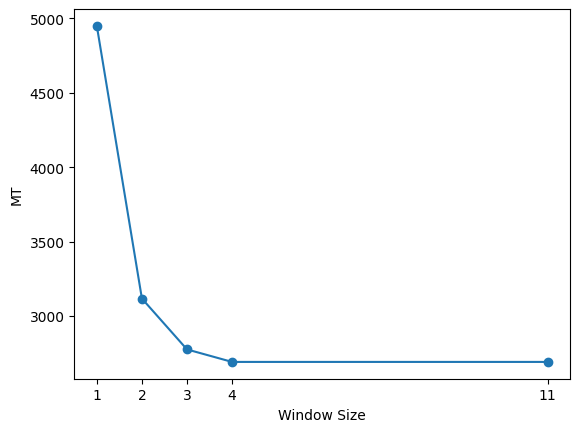

CPU times: user 9.09 s, sys: 222 ms, total: 9.31 s
Wall time: 8.69 s


In [23]:
%%time 
MT = {window: [] for window in window_sizes}
num_sims = 500
for window in MT.keys():
    model = DriftDiffusionModel_Optimzied(seq, specific_seq, visual_drifts, np.zeros((5, seq_length)), diffusion = 0, threshold = threshold, window_size=window, visual_delay=150, planning_capacity=4, planning_param=2)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        MT[window].append(sum(IPIs))


#Calculating mean and std for each window size
MT_mean = {window: np.mean(MT_vals) for window, MT_vals in MT.items()}
MT_std = {window: np.std(MT_vals) for window, MT_vals in MT.items()}

plt.errorbar(MT_mean.keys(), MT_mean.values(), yerr=list(MT_std.values()), fmt='-o')
plt.xticks(window_sizes)
plt.xlabel('Window Size')
plt.ylabel('MT')
plt.show()


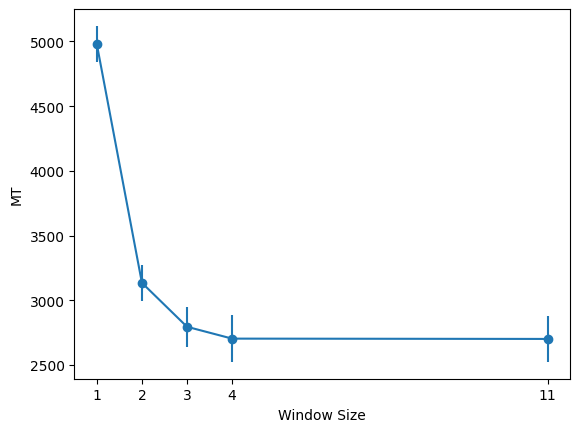

CPU times: user 4.98 s, sys: 14.8 ms, total: 4.99 s
Wall time: 5.01 s


In [ ]:
%%time 
MT = {window: [] for window in window_sizes}
num_sims = 500
for window in MT.keys():
    model = DriftDiffusionModel_Optimzied(seq, specific_seq, visual_drifts, np.zeros((5, seq_length)), diffusion, threshold, window_size=window, visual_delay=150, planning_capacity=4, planning_param=2)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        MT[window].append(sum(IPIs))


#Calculating mean and std for each window size
MT_mean = {window: np.mean(MT_vals) for window, MT_vals in MT.items()}
MT_std = {window: np.std(MT_vals) for window, MT_vals in MT.items()}

plt.errorbar(MT_mean.keys(), MT_mean.values(), yerr=list(MT_std.values()), fmt='-o')
plt.xticks(window_sizes)
plt.xlabel('Window Size')
plt.ylabel('MT')
plt.show()


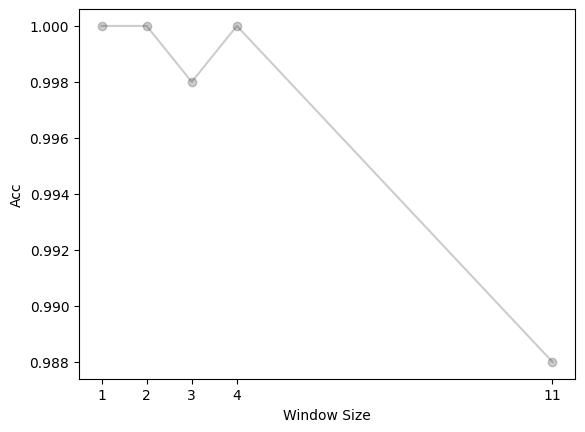

CPU times: user 5.03 s, sys: 6.42 ms, total: 5.03 s
Wall time: 4.95 s


In [22]:
%%time 
MT = {window: [] for window in window_sizes}
num_sims = 500
for window in MT.keys():
    model = DriftDiffusionModel_Optimzied(seq, specific_seq, visual_drifts, np.zeros((5, seq_length)), diffusion = diffusion, threshold = threshold , window_size=window, visual_delay=150, planning_capacity=4, planning_param=2)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        MT[window].append(check_evidence_to_seq(evidence, seq))


#Calculating mean and std for each window size
MT_mean = {window: np.sum(MT_vals) for window, MT_vals in MT.items()}
# MT_std = {window: np.std(MT_vals) for window, MT_vals in MT.items()}

# plt.errorbar(MT_mean.keys(), MT_mean.values(), yerr=list(MT_std.values()), fmt='-o')
plt.errorbar(MT_mean.keys(), np.array(list(MT_mean.values()))/num_sims, fmt='-o', color = 'black', alpha = 0.2)

plt.xticks(window_sizes)
plt.xlabel('Window Size')
plt.ylabel('Acc')
plt.show()


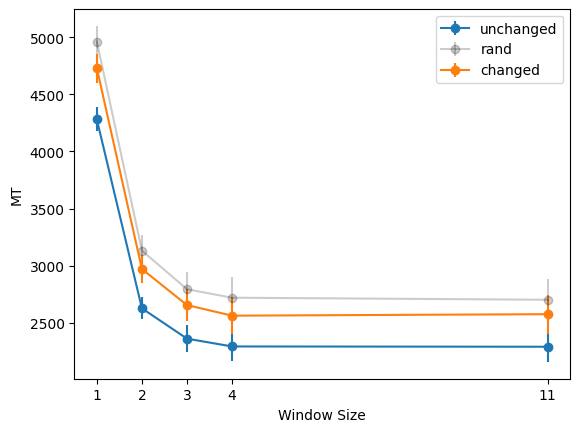

CPU times: user 13.6 s, sys: 49 ms, total: 13.7 s
Wall time: 13.6 s


In [25]:
%%time 
kwargs = {'changed': {'color': 'C1', 'alpha': 1}, 'unchanged': {'color': 'C0', 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}

MT = {window: [] for window in window_sizes}
num_sims = 500
for window in MT.keys():
    model = DriftDiffusionModel_Optimzied(seq, specific_seq, visual_drifts, memory_drifts, diffusion, threshold, window_size=window, visual_delay=150, planning_capacity=4, planning_param=2)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        MT[window].append(sum(IPIs))


#Calculating mean and std for each window size
MT_mean = {window: np.mean(MT_vals) for window, MT_vals in MT.items()}
MT_std = {window: np.std(MT_vals) for window, MT_vals in MT.items()}

plt.errorbar(MT_mean.keys(), MT_mean.values(), yerr=list(MT_std.values()), fmt='-o', label = 'unchanged', **kwargs['unchanged'])

MT = {window: [] for window in window_sizes}
for window in MT.keys():
    model = DriftDiffusionModel_Optimzied(seq, specific_seq,  visual_drifts, np.zeros((5, seq_length)), diffusion, threshold, window_size=window, visual_delay=150, planning_capacity=4, planning_param=2)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        MT[window].append(sum(IPIs))


#Calculating mean and std for each window size
MT_mean = {window: np.mean(MT_vals) for window, MT_vals in MT.items()}
MT_std = {window: np.std(MT_vals) for window, MT_vals in MT.items()}

plt.errorbar(MT_mean.keys(), MT_mean.values(), yerr=list(MT_std.values()), fmt='-o', label = 'rand', **kwargs['rand'])


MT = {window: [] for window in window_sizes}
for window in MT.keys():
    model = DriftDiffusionModel_Optimzied(seq, specific_seq_changed, visual_drifts, memory_drifts, diffusion, threshold, window_size=window, visual_delay=150, planning_capacity=4, planning_param=2)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        MT[window].append(sum(IPIs))


#Calculating mean and std for each window size
MT_mean = {window: np.mean(MT_vals) for window, MT_vals in MT.items()}
MT_std = {window: np.std(MT_vals) for window, MT_vals in MT.items()}

plt.errorbar(MT_mean.keys(), MT_mean.values(), yerr=list(MT_std.values()), fmt='-o', label = 'changed', **kwargs['changed'])





plt.xticks(window_sizes)
plt.xlabel('Window Size')
plt.ylabel('MT')
plt.legend()
plt.show()


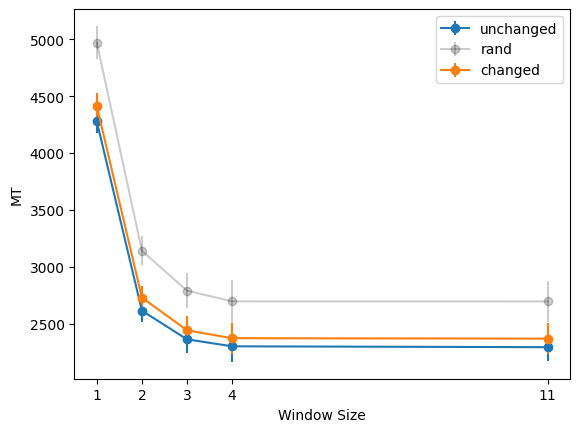

CPU times: user 13.6 s, sys: 45.9 ms, total: 13.7 s
Wall time: 13.6 s


In [26]:
%%time 
kwargs = {'changed': {'color': 'C1', 'alpha': 1}, 'unchanged': {'color': 'C0', 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}

MT = {window: [] for window in window_sizes}
num_sims = 500
for window in MT.keys():
    model = DriftDiffusionModel_Optimzied(seq, specific_seq, visual_drifts, memory_drifts, diffusion, threshold, window_size=window, visual_delay=150, planning_capacity=4, planning_param=2)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        MT[window].append(sum(IPIs))


#Calculating mean and std for each window size
MT_mean = {window: np.mean(MT_vals) for window, MT_vals in MT.items()}
MT_std = {window: np.std(MT_vals) for window, MT_vals in MT.items()}

plt.errorbar(MT_mean.keys(), MT_mean.values(), yerr=list(MT_std.values()), fmt='-o', label = 'unchanged', **kwargs['unchanged'])

MT = {window: [] for window in window_sizes}
for window in MT.keys():
    model = DriftDiffusionModel_Optimzied(seq, specific_seq,  visual_drifts, np.zeros((5, seq_length)), diffusion, threshold, window_size=window, visual_delay=150, planning_capacity=4, planning_param=2)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        MT[window].append(sum(IPIs))


#Calculating mean and std for each window size
MT_mean = {window: np.mean(MT_vals) for window, MT_vals in MT.items()}
MT_std = {window: np.std(MT_vals) for window, MT_vals in MT.items()}

plt.errorbar(MT_mean.keys(), MT_mean.values(), yerr=list(MT_std.values()), fmt='-o', label = 'rand', **kwargs['rand'])


MT = {window: [] for window in window_sizes}
for window in MT.keys():
    model = DriftDiffusionModel_Optimzied(specific_seq_changed_one_digit, specific_seq, visual_drifts, memory_drifts, diffusion, threshold, window_size=window, visual_delay=150, planning_capacity=4, planning_param=2)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        MT[window].append(sum(IPIs))


#Calculating mean and std for each window size
MT_mean = {window: np.mean(MT_vals) for window, MT_vals in MT.items()}
MT_std = {window: np.std(MT_vals) for window, MT_vals in MT.items()}

plt.errorbar(MT_mean.keys(), MT_mean.values(), yerr=list(MT_std.values()), fmt='-o', label = 'changed', **kwargs['changed'])





plt.xticks(window_sizes)
plt.xlabel('Window Size')
plt.ylabel('MT')
plt.legend()
plt.show()


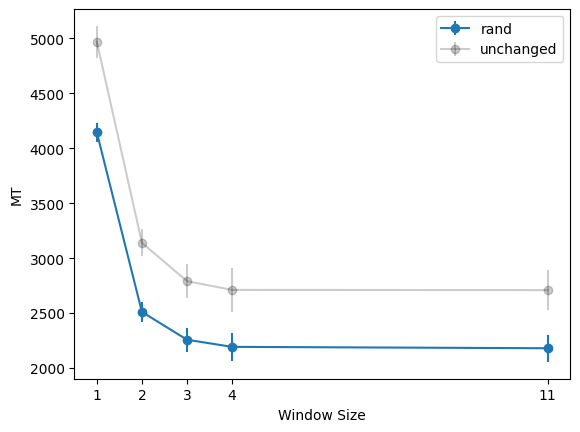

CPU times: user 9.58 s, sys: 52.7 ms, total: 9.63 s
Wall time: 9.59 s


In [ ]:
%%time 
kwargs = {'changed': {'color': 'C1', 'alpha': 1}, 'unchanged': {'color': 'C0', 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}

MT = {window: [] for window in window_sizes}
num_sims = 500
for window in MT.keys():
    model = DriftDiffusionModel_Optimzied(seq, specific_seq, visual_drifts, memory_drifts, diffusion, threshold, window_size=window, visual_delay=150, planning_capacity=4, planning_param=2)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        MT[window].append(sum(IPIs))


#Calculating mean and std for each window size
MT_mean = {window: np.mean(MT_vals) for window, MT_vals in MT.items()}
MT_std = {window: np.std(MT_vals) for window, MT_vals in MT.items()}

plt.errorbar(MT_mean.keys(), MT_mean.values(), yerr=list(MT_std.values()), fmt='-o', label = 'rand', **kwargs['unchanged'])

MT = {window: [] for window in window_sizes}
for window in MT.keys():
    model = DriftDiffusionModel_Optimzied(seq, specific_seq, visual_drifts, np.zeros((5, seq_length)), diffusion, threshold, window_size=window, visual_delay=150, planning_capacity=4, planning_param=2)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        MT[window].append(sum(IPIs))


#Calculating mean and std for each window size
MT_mean = {window: np.mean(MT_vals) for window, MT_vals in MT.items()}
MT_std = {window: np.std(MT_vals) for window, MT_vals in MT.items()}

plt.errorbar(MT_mean.keys(), MT_mean.values(), yerr=list(MT_std.values()), fmt='-o', label = 'unchanged', **kwargs['rand'])






plt.xticks(window_sizes)
plt.xlabel('Window Size')
plt.ylabel('MT')
plt.legend()
plt.show()


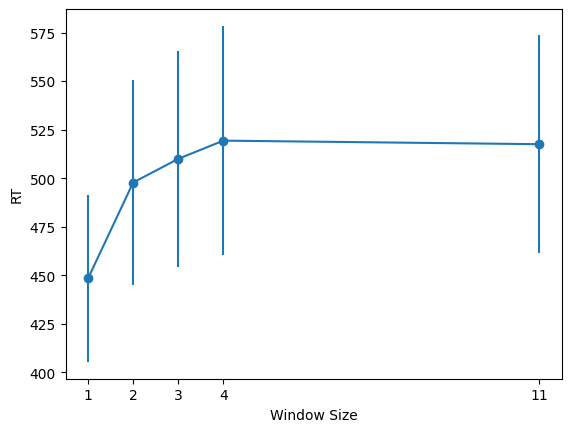

CPU times: user 5.91 s, sys: 9.41 ms, total: 5.92 s
Wall time: 5.97 s


In [25]:
%%time
RT = {window: [] for window in window_sizes}
num_sims = 500
for window in RT.keys():
    model = DriftDiffusionModel_Optimzied(seq, specific_seq, visual_drifts, np.zeros((5, seq_length)), diffusion, threshold, window_size=window, visual_delay=150, planning_capacity=4, planning_param=2)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        RT[window].append(IPIs[0])


#Calculating mean and std for each window size
RT_mean = {window: np.mean(RT_vals) for window, RT_vals in RT.items()}
RT_std = {window: np.std(RT_vals) for window, RT_vals in RT.items()}

plt.errorbar(RT_mean.keys(), RT_mean.values(), yerr=list(RT_std.values()), fmt='-o')
plt.xticks(window_sizes)
plt.xlabel('Window Size')
plt.ylabel('RT')
plt.show()


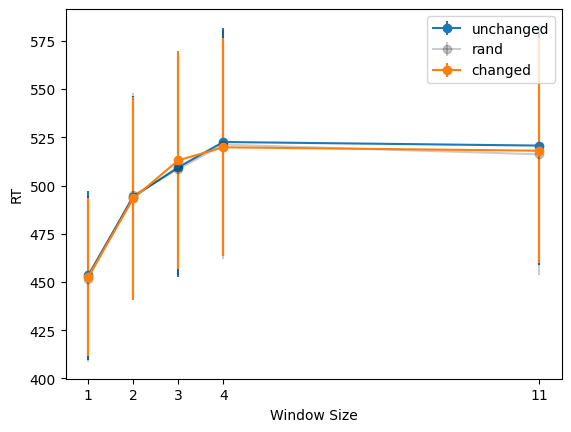

CPU times: user 16.6 s, sys: 1.7 s, total: 18.3 s
Wall time: 16.7 s


In [26]:
%%time 
kwargs = {'changed': {'color': 'C1', 'alpha': 1}, 'unchanged': {'color': 'C0', 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}

RT = {window: [] for window in window_sizes}
num_sims = 500
for window in RT.keys():
    model = DriftDiffusionModel_Optimzied(seq, specific_seq, visual_drifts, memory_drifts, diffusion, threshold, window_size=window, visual_delay=150, planning_capacity=4, planning_param=2)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        RT[window].append(IPIs[0])


#Calculating mean and std for each window size
RT_mean = {window: np.mean(RT_vals) for window, RT_vals in RT.items()}
RT_std = {window: np.std(RT_vals) for window, RT_vals in RT.items()}

plt.errorbar(RT_mean.keys(), RT_mean.values(), yerr=list(RT_std.values()), fmt='-o', label = 'unchanged', **kwargs['unchanged'])

RT = {window: [] for window in window_sizes}
for window in RT.keys():
    model = DriftDiffusionModel_Optimzied(seq, specific_seq, visual_drifts, np.zeros((5, seq_length)), diffusion, threshold, window_size=window, visual_delay=150, planning_capacity=4, planning_param=2)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        RT[window].append(IPIs[0])


#Calculating mean and std for each window size
RT_mean = {window: np.mean(RT_vals) for window, RT_vals in RT.items()}
RT_std = {window: np.std(RT_vals) for window, RT_vals in RT.items()}

plt.errorbar(RT_mean.keys(), RT_mean.values(), yerr=list(RT_std.values()), fmt='-o', label = 'rand', **kwargs['rand'])


RT = {window: [] for window in window_sizes}
for window in RT.keys():
    model = DriftDiffusionModel_Optimzied(seq, specific_seq_changed, visual_drifts, memory_drifts, diffusion, threshold, window_size=window, visual_delay=150, planning_capacity=4, planning_param=2)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        RT[window].append(IPIs[0])


#Calculating mean and std for each window size
RT_mean = {window: np.mean(RT_vals) for window, RT_vals in RT.items()}
RT_std = {window: np.std(RT_vals) for window, RT_vals in RT.items()}

plt.errorbar(RT_mean.keys(), RT_mean.values(), yerr=list(RT_std.values()), fmt='-o', label = 'changed', **kwargs['changed'])






plt.xticks(window_sizes)
plt.xlabel('Window Size')
plt.ylabel('RT')
plt.legend()
plt.show()


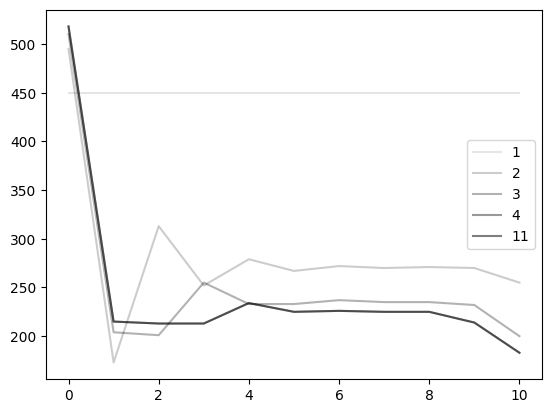

CPU times: user 10.3 s, sys: 55.9 ms, total: 10.4 s
Wall time: 10.3 s


In [ ]:
%%time 
num_sims = 1000
IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}

for window in IPI.keys():
    model = DriftDiffusionModel_Optimzied(seq, specific_seq, visual_drifts, np.zeros((5, seq_length)), diffusion = 0, threshold = threshold, window_size=window, visual_delay=150, planning_capacity=4, planning_param=2)
    for sim in range(num_sims):
        IPIs, evidence = model.simulate()
        IPI[window][:, sim ] = IPIs


#Calculating mean and std for each window size
IPI_mean = {window: IPI_vals.mean(axis = 1) for window, IPI_vals in IPI.items()}
IPI_std = {window: IPI_vals.std(axis = 1) for window, IPI_vals in IPI.items()}


for idx, window in enumerate(IPI.keys()):
    # plt.errorbar(range(seq_length), IPI_mean[window], yerr = IPI_std[window]/np.sqrt(num_sims), label = window, color = 'black',  alpha = (idx+1)/(2 *len(window_sizes)))
    plt.errorbar(range(seq_length), IPI_mean[window], label = window, color = 'black', alpha = (idx+1)/(2 *len(window_sizes)))



plt.legend()
plt.show()

# plt.errorbar(RT_mean.keys(), RT_mean.values(), yerr=list(RT_std.values()), fmt='-o')
# plt.xticks(window_sizes)
# plt.xlabel('Window Size')
# plt.ylabel('RT')
# plt.show()


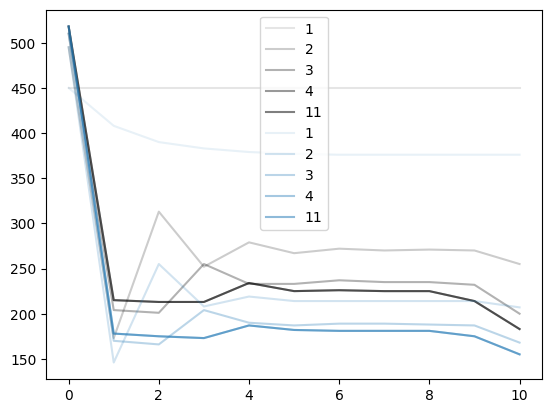

CPU times: user 676 ms, sys: 2.51 ms, total: 679 ms
Wall time: 273 ms


In [27]:
%%time 
kwargs = {'changed': {'color': 'C1', 'alpha': 1}, 'unchanged': {'color': 'C0', 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}
num_sims = 1
IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}

for window in IPI.keys():
    model = DriftDiffusionModel_Optimzied(seq, specific_seq, visual_drifts, np.zeros((5, seq_length)), diffusion = 0, threshold = threshold, window_size=window, visual_delay=150, planning_capacity=4, planning_param=2)
    for sim in range(num_sims):
        IPIs, evidence = model.simulate()
        IPI[window][:, sim ] = IPIs


#Calculating mean and std for each window size
IPI_mean = {window: IPI_vals.mean(axis = 1) for window, IPI_vals in IPI.items()}
IPI_std = {window: IPI_vals.std(axis = 1) for window, IPI_vals in IPI.items()}


for idx, window in enumerate(IPI.keys()):
    # plt.errorbar(range(seq_length), IPI_mean[window], yerr = IPI_std[window]/np.sqrt(num_sims), label = window, color = 'black',  alpha = (idx+1)/(2 *len(window_sizes)))
    plt.errorbar(range(seq_length), IPI_mean[window], label = window, color = 'black', alpha = (idx+1)/(2 *len(window_sizes)))



IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}

for window in IPI.keys():
    model = DriftDiffusionModel_Optimzied(seq, specific_seq, visual_drifts, memory_drifts, diffusion = 0, threshold = threshold, window_size=window, visual_delay=150, planning_capacity=4, planning_param=2)
    for sim in range(num_sims):
        IPIs, evidence = model.simulate()
        IPI[window][:, sim ] = IPIs


#Calculating mean and std for each window size
IPI_mean = {window: IPI_vals.mean(axis = 1) for window, IPI_vals in IPI.items()}
IPI_std = {window: IPI_vals.std(axis = 1) for window, IPI_vals in IPI.items()}


for idx, window in enumerate(IPI.keys()):
    # plt.errorbar(range(seq_length), IPI_mean[window], yerr = IPI_std[window]/np.sqrt(num_sims), label = window, color = 'black',  alpha = (idx+1)/(2 *len(window_sizes)))
    plt.errorbar(range(seq_length), IPI_mean[window], label = window, color = 'C0', alpha = (idx+1)/(2 *len(window_sizes)))

plt.legend()
plt.show()

# plt.errorbar(RT_mean.keys(), RT_mean.values(), yerr=list(RT_std.values()), fmt='-o')
# plt.xticks(window_sizes)
# plt.xlabel('Window Size')
# plt.ylabel('RT')
# plt.show()


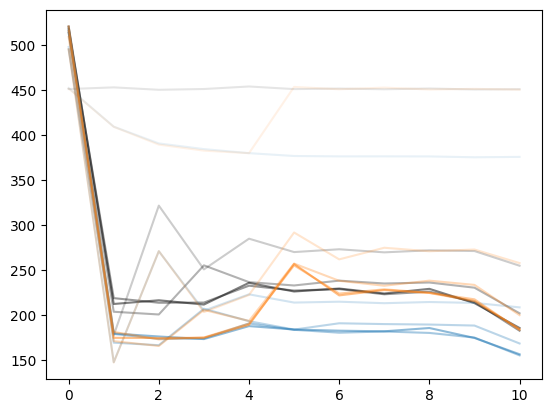

In [28]:

num_sims = 1000
IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}

for window in IPI.keys():
    model = DriftDiffusionModel_Optimzied(seq, specific_seq, visual_drifts, np.zeros((5, seq_length)), diffusion, threshold, window_size=window, visual_delay=150, planning_capacity=4, planning_param=2)
    for sim in range(num_sims):
        IPIs, evidence = model.simulate()
        IPI[window][:, sim ] = IPIs


#Calculating mean and std for each window size
IPI_mean = {window: IPI_vals.mean(axis = 1) for window, IPI_vals in IPI.items()}
IPI_std = {window: IPI_vals.std(axis = 1) for window, IPI_vals in IPI.items()}


for idx, window in enumerate(IPI.keys()):
    # plt.errorbar(range(seq_length), IPI_mean[window], yerr = IPI_std[window]/np.sqrt(num_sims), label = window, color = 'black',  alpha = (idx+1)/(2 *len(window_sizes)))
    plt.errorbar(range(seq_length), IPI_mean[window], label = window, color = 'black', alpha = (idx+1)/(2 *len(window_sizes)))


IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}

for window in IPI.keys():
    model = DriftDiffusionModel_Optimzied(seq, specific_seq, visual_drifts, memory_drifts, diffusion, threshold, window_size=window, visual_delay=150, planning_capacity=4, planning_param=2)
    for sim in range(num_sims):
        IPIs, evidence = model.simulate()
        IPI[window][:, sim ] = IPIs


#Calculating mean and std for each window size
IPI_mean = {window: IPI_vals.mean(axis = 1) for window, IPI_vals in IPI.items()}
IPI_std = {window: IPI_vals.std(axis = 1) for window, IPI_vals in IPI.items()}


for idx, window in enumerate(IPI.keys()):
    # plt.errorbar(range(seq_length), IPI_mean[window], yerr = IPI_std[window]/np.sqrt(num_sims), label = window, color = 'black',  alpha = (idx+1)/(2 *len(window_sizes)))
    plt.errorbar(range(seq_length), IPI_mean[window], label = window, color = 'C0', alpha = (idx+1)/(2 *len(window_sizes)))



IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}

for window in IPI.keys():
    model = DriftDiffusionModel_Optimzied(seq, specific_seq_changed, visual_drifts, memory_drifts, diffusion, threshold, window_size=window, visual_delay=150, planning_capacity=4, planning_param=2)
    for sim in range(num_sims):
        IPIs, evidence = model.simulate()
        IPI[window][:, sim ] = IPIs


#Calculating mean and std for each window size
IPI_mean = {window: IPI_vals.mean(axis = 1) for window, IPI_vals in IPI.items()}
IPI_std = {window: IPI_vals.std(axis = 1) for window, IPI_vals in IPI.items()}


for idx, window in enumerate(IPI.keys()):
    # plt.errorbar(range(seq_length), IPI_mean[window], yerr = IPI_std[window]/np.sqrt(num_sims), label = window, color = 'black',  alpha = (idx+1)/(2 *len(window_sizes)))
    plt.errorbar(range(seq_length), IPI_mean[window], label = window, color = 'C1', alpha = (idx+1)/(2 *len(window_sizes)))


# plt.legend()
plt.show()

# plt.errorbar(RT_mean.keys(), RT_mean.values(), yerr=list(RT_std.values()), fmt='-o')
# plt.xticks(window_sizes)
# plt.xlabel('Window Size')
# plt.ylabel('RT')
# plt.show()


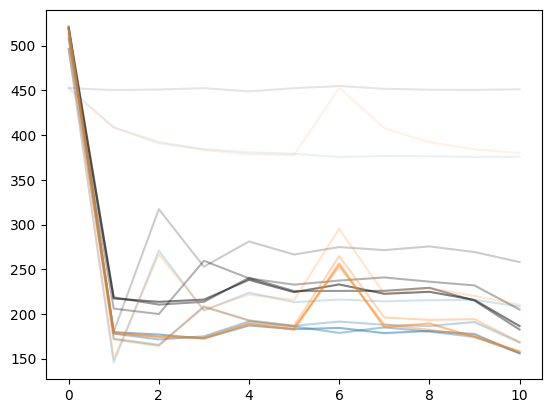

In [27]:

num_sims = 1000
IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}

for window in IPI.keys():
    model = DriftDiffusionModel_Optimzied(seq, specific_seq, visual_drifts, np.zeros((5, seq_length)), diffusion, threshold, window_size=window, visual_delay=150, planning_capacity=4, planning_param=2)
    for sim in range(num_sims):
        IPIs, evidence = model.simulate()
        IPI[window][:, sim ] = IPIs


#Calculating mean and std for each window size
IPI_mean = {window: IPI_vals.mean(axis = 1) for window, IPI_vals in IPI.items()}
IPI_std = {window: IPI_vals.std(axis = 1) for window, IPI_vals in IPI.items()}


for idx, window in enumerate(IPI.keys()):
    # plt.errorbar(range(seq_length), IPI_mean[window], yerr = IPI_std[window]/np.sqrt(num_sims), label = window, color = 'black',  alpha = (idx+1)/(2 *len(window_sizes)))
    plt.errorbar(range(seq_length), IPI_mean[window], label = window, color = 'black', alpha = (idx+1)/(2 *len(window_sizes)))


IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}

for window in IPI.keys():
    model = DriftDiffusionModel_Optimzied(seq, specific_seq, visual_drifts, memory_drifts, diffusion, threshold, window_size=window, visual_delay=150, planning_capacity=4, planning_param=2)
    for sim in range(num_sims):
        IPIs, evidence = model.simulate()
        IPI[window][:, sim ] = IPIs


#Calculating mean and std for each window size
IPI_mean = {window: IPI_vals.mean(axis = 1) for window, IPI_vals in IPI.items()}
IPI_std = {window: IPI_vals.std(axis = 1) for window, IPI_vals in IPI.items()}


for idx, window in enumerate(IPI.keys()):
    # plt.errorbar(range(seq_length), IPI_mean[window], yerr = IPI_std[window]/np.sqrt(num_sims), label = window, color = 'black',  alpha = (idx+1)/(2 *len(window_sizes)))
    plt.errorbar(range(seq_length), IPI_mean[window], label = window, color = 'C0', alpha = (idx+1)/(2 *len(window_sizes)))



IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}

for window in IPI.keys():
    model = DriftDiffusionModel_Optimzied(specific_seq_changed_one_digit, specific_seq, visual_drifts, memory_drifts, diffusion, threshold, window_size=window, visual_delay=150, planning_capacity=4, planning_param=2)
    for sim in range(num_sims):
        IPIs, evidence = model.simulate()
        IPI[window][:, sim ] = IPIs


#Calculating mean and std for each window size
IPI_mean = {window: IPI_vals.mean(axis = 1) for window, IPI_vals in IPI.items()}
IPI_std = {window: IPI_vals.std(axis = 1) for window, IPI_vals in IPI.items()}


for idx, window in enumerate(IPI.keys()):
    # plt.errorbar(range(seq_length), IPI_mean[window], yerr = IPI_std[window]/np.sqrt(num_sims), label = window, color = 'black',  alpha = (idx+1)/(2 *len(window_sizes)))
    plt.errorbar(range(seq_length), IPI_mean[window], label = window, color = 'C1', alpha = (idx+1)/(2 *len(window_sizes)))


# plt.legend()
plt.show()

# plt.errorbar(RT_mean.keys(), RT_mean.values(), yerr=list(RT_std.values()), fmt='-o')
# plt.xticks(window_sizes)
# plt.xlabel('Window Size')
# plt.ylabel('RT')
# plt.show()


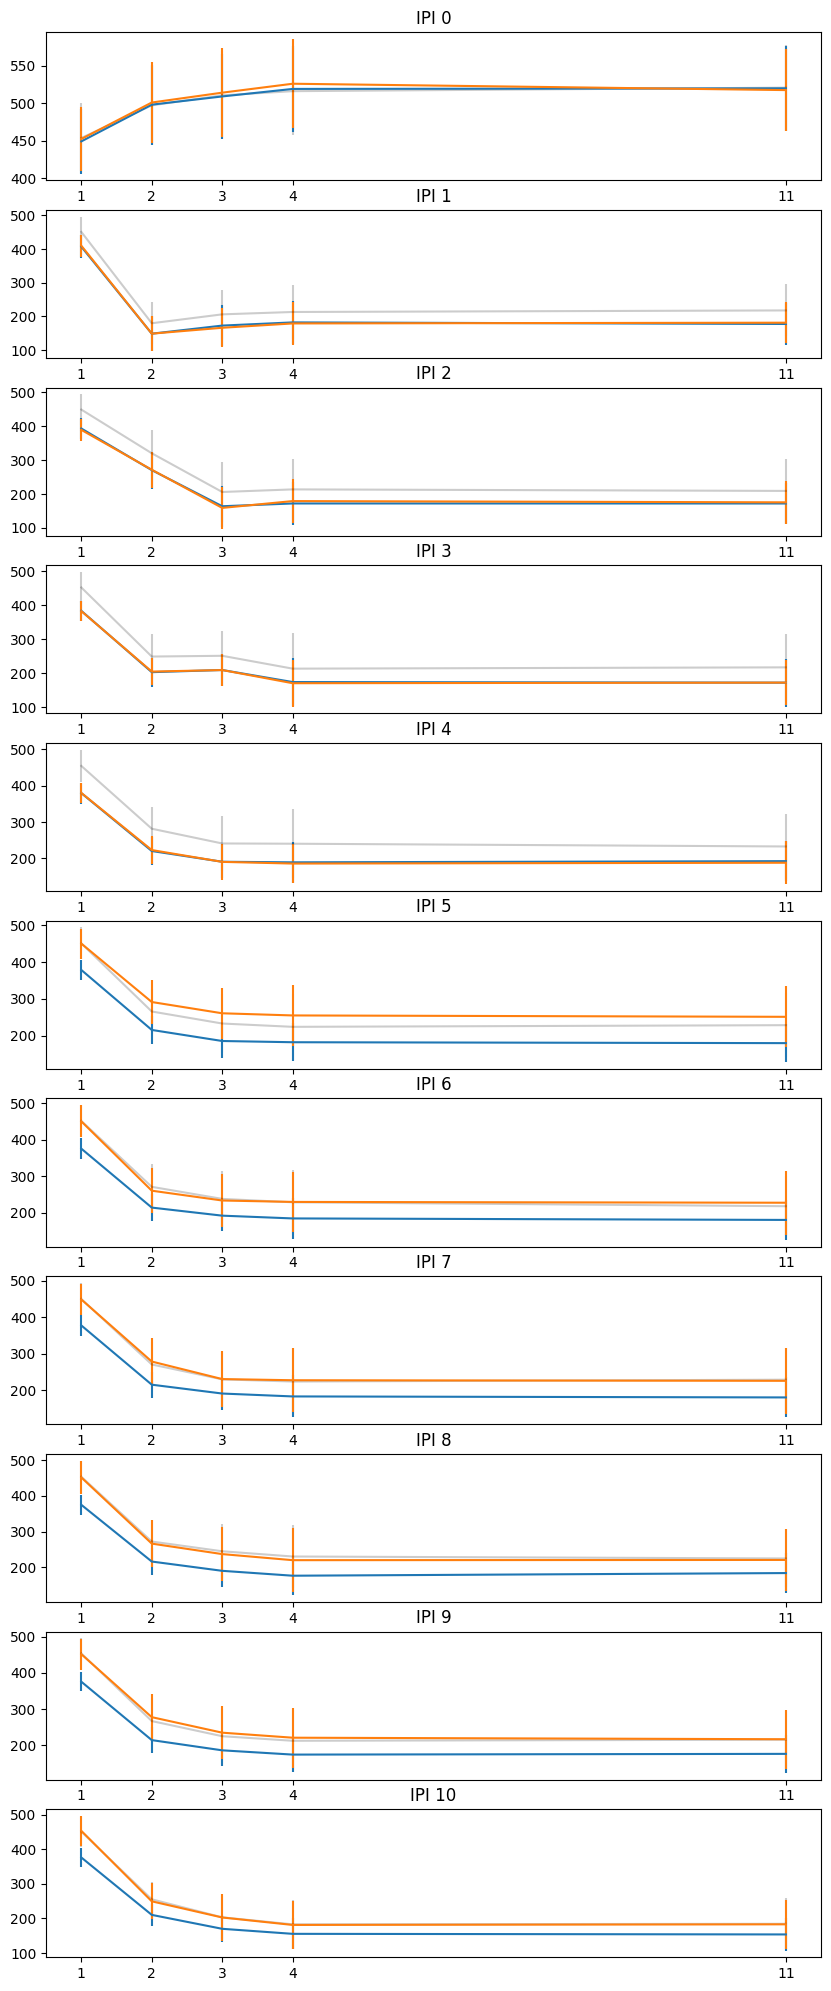

In [30]:
fig, axs = plt.subplots(seq_length, figsize = (10,25))
num_sims = 500
IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}

for window in IPI.keys():
    model = DriftDiffusionModel_Optimzied(seq, specific_seq, visual_drifts, np.zeros((5, seq_length)), diffusion, threshold, window_size=window, visual_delay=150, planning_capacity=4, planning_param=2)
    for sim in range(num_sims):
        IPIs, evidence = model.simulate()
        IPI[window][:, sim ] = IPIs


#Calculating mean and std for each window size
IPI_mean = {window: IPI_vals.mean(axis = 1) for window, IPI_vals in IPI.items()}
IPI_std = {window: IPI_vals.std(axis = 1) for window, IPI_vals in IPI.items()}


for press in range(seq_length):
    axs[press].errorbar(IPI.keys(), [ipis[press] for ipis in IPI_mean.values()], yerr = [ipis[press] for ipis in IPI_std.values()], color = 'black', alpha = 0.2)
    axs[press].set_xticks(list(IPI.keys()))
    axs[press].set_title(f'IPI {press}')


IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}

for window in IPI.keys():
    model = DriftDiffusionModel_Optimzied(seq, specific_seq, visual_drifts, memory_drifts, diffusion, threshold, window_size=window, visual_delay=150, planning_capacity=4, planning_param=2)
    for sim in range(num_sims):
        IPIs, evidence = model.simulate()
        IPI[window][:, sim ] = IPIs


#Calculating mean and std for each window size
IPI_mean = {window: IPI_vals.mean(axis = 1) for window, IPI_vals in IPI.items()}
IPI_std = {window: IPI_vals.std(axis = 1) for window, IPI_vals in IPI.items()}


for press in range(seq_length):
    axs[press].errorbar(IPI.keys(), [ipis[press] for ipis in IPI_mean.values()], yerr = [ipis[press] for ipis in IPI_std.values()], color = 'C0')
    axs[press].set_xticks(list(IPI.keys()))
    axs[press].set_title(f'IPI {press}')



IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}

for window in IPI.keys():
    model = DriftDiffusionModel_Optimzied(seq, specific_seq_changed, visual_drifts, memory_drifts, diffusion, threshold, window_size=window, visual_delay=150, planning_capacity=4, planning_param=2)
    for sim in range(num_sims):
        IPIs, evidence = model.simulate()
        IPI[window][:, sim ] = IPIs


#Calculating mean and std for each window size
IPI_mean = {window: IPI_vals.mean(axis = 1) for window, IPI_vals in IPI.items()}
IPI_std = {window: IPI_vals.std(axis = 1) for window, IPI_vals in IPI.items()}


for press in range(seq_length):
    axs[press].errorbar(IPI.keys(), [ipis[press] for ipis in IPI_mean.values()], yerr = [ipis[press] for ipis in IPI_std.values()], color = 'C1')
    axs[press].set_xticks(list(IPI.keys()))
    axs[press].set_title(f'IPI {press}')


# plt.legend()
plt.show()

# plt.errorbar(RT_mean.keys(), RT_mean.values(), yerr=list(RT_std.values()), fmt='-o')
# plt.xticks(window_sizes)
# plt.xlabel('Window Size')
# plt.ylabel('RT')
# plt.show()


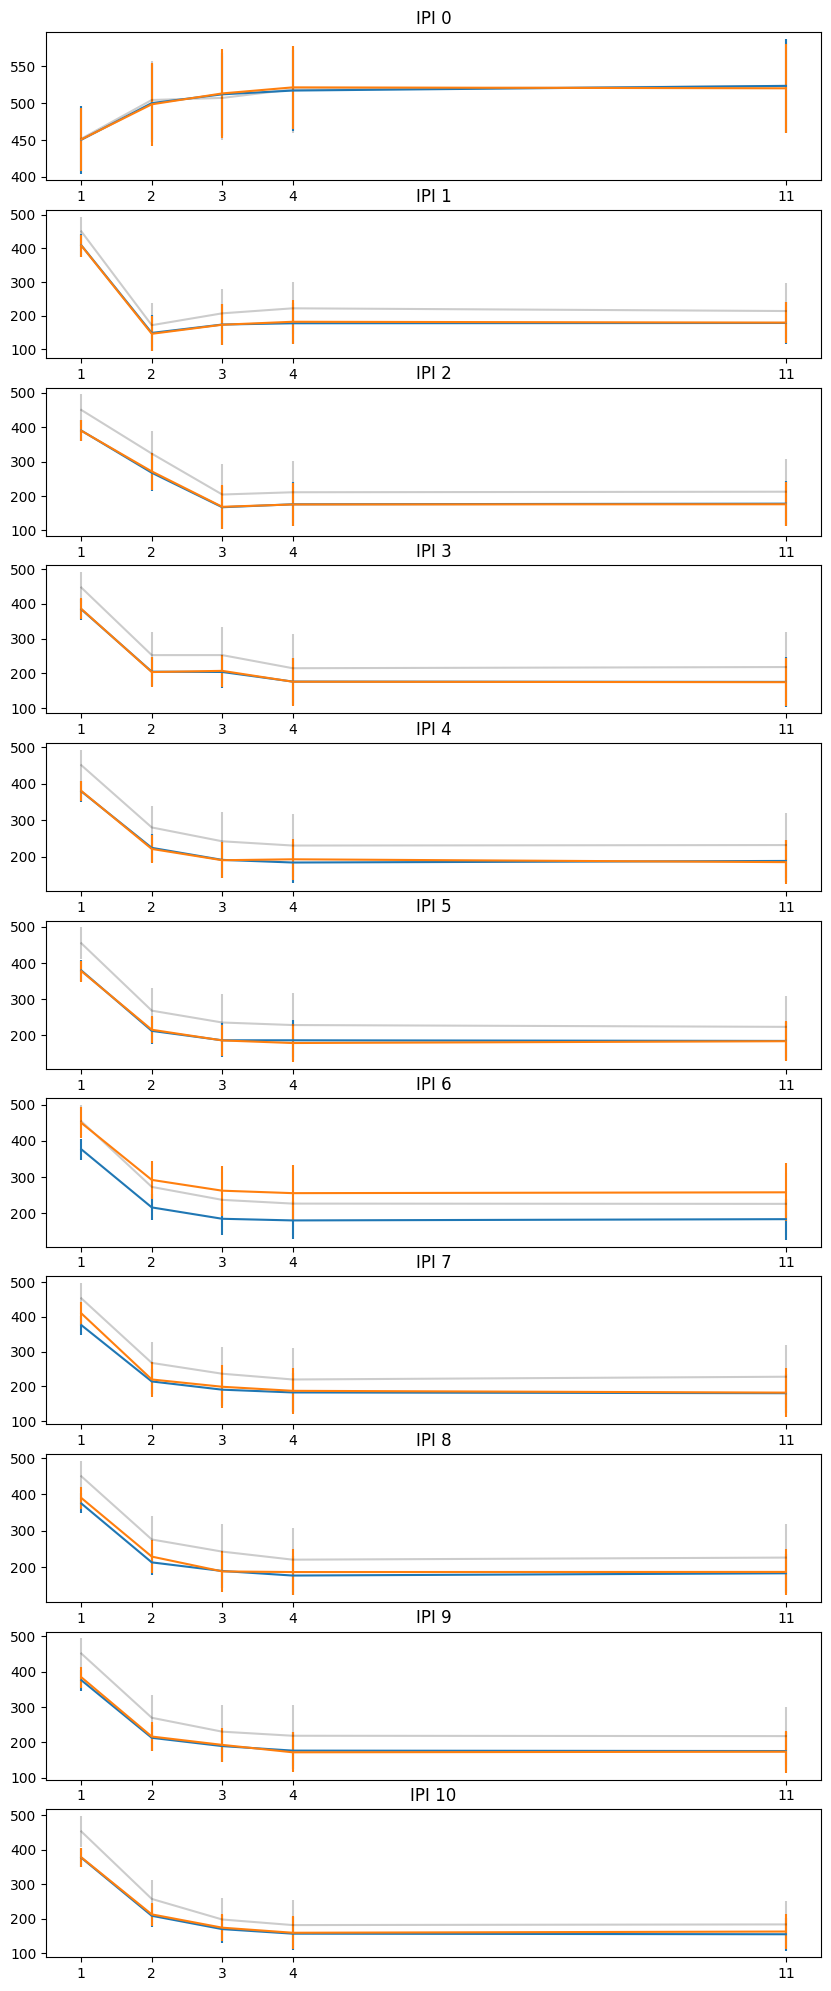

In [28]:
fig, axs = plt.subplots(seq_length, figsize = (10,25))
num_sims = 500
IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}

for window in IPI.keys():
    model = DriftDiffusionModel_Optimzied(seq, specific_seq, visual_drifts, np.zeros((5, seq_length)), diffusion, threshold, window_size=window, visual_delay=150, planning_capacity=4, planning_param=2)
    for sim in range(num_sims):
        IPIs, evidence = model.simulate()
        IPI[window][:, sim ] = IPIs


#Calculating mean and std for each window size
IPI_mean = {window: IPI_vals.mean(axis = 1) for window, IPI_vals in IPI.items()}
IPI_std = {window: IPI_vals.std(axis = 1) for window, IPI_vals in IPI.items()}


for press in range(seq_length):
    axs[press].errorbar(IPI.keys(), [ipis[press] for ipis in IPI_mean.values()], yerr = [ipis[press] for ipis in IPI_std.values()], color = 'black', alpha = 0.2)
    axs[press].set_xticks(list(IPI.keys()))
    axs[press].set_title(f'IPI {press}')


IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}

for window in IPI.keys():
    model = DriftDiffusionModel_Optimzied(seq, specific_seq, visual_drifts, memory_drifts, diffusion, threshold, window_size=window, visual_delay=150, planning_capacity=4, planning_param=2)
    for sim in range(num_sims):
        IPIs, evidence = model.simulate()
        IPI[window][:, sim ] = IPIs


#Calculating mean and std for each window size
IPI_mean = {window: IPI_vals.mean(axis = 1) for window, IPI_vals in IPI.items()}
IPI_std = {window: IPI_vals.std(axis = 1) for window, IPI_vals in IPI.items()}


for press in range(seq_length):
    axs[press].errorbar(IPI.keys(), [ipis[press] for ipis in IPI_mean.values()], yerr = [ipis[press] for ipis in IPI_std.values()], color = 'C0')
    axs[press].set_xticks(list(IPI.keys()))
    axs[press].set_title(f'IPI {press}')



IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}

for window in IPI.keys():
    model = DriftDiffusionModel_Optimzied(specific_seq_changed_one_digit, specific_seq, visual_drifts, memory_drifts, diffusion, threshold, window_size=window, visual_delay=150, planning_capacity=4, planning_param=2)
    for sim in range(num_sims):
        IPIs, evidence = model.simulate()
        IPI[window][:, sim ] = IPIs


#Calculating mean and std for each window size
IPI_mean = {window: IPI_vals.mean(axis = 1) for window, IPI_vals in IPI.items()}
IPI_std = {window: IPI_vals.std(axis = 1) for window, IPI_vals in IPI.items()}


for press in range(seq_length):
    axs[press].errorbar(IPI.keys(), [ipis[press] for ipis in IPI_mean.values()], yerr = [ipis[press] for ipis in IPI_std.values()], color = 'C1')
    axs[press].set_xticks(list(IPI.keys()))
    axs[press].set_title(f'IPI {press}')


# plt.legend()
plt.show()

# plt.errorbar(RT_mean.keys(), RT_mean.values(), yerr=list(RT_std.values()), fmt='-o')
# plt.xticks(window_sizes)
# plt.xlabel('Window Size')
# plt.ylabel('RT')
# plt.show()


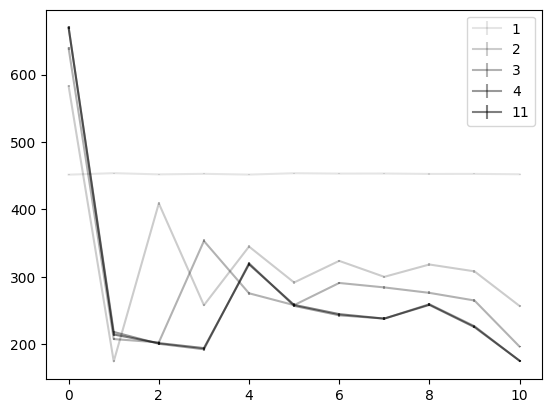

In [ ]:
num_sims = 10000
IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}

for window in IPI.keys():
    model = DriftDiffusionModel_Optimzied(drifts, diffusion, threshold, window_size=window, visual_delay=150, planning_capacity=4, planning_param=2)
    for sim in range(num_sims):
        IPIs = model.simulate()
        IPI[window][:, sim ] = IPIs


#Calculating mean and std for each window size
IPI_mean = {window: IPI_vals.mean(axis = 1) for window, IPI_vals in IPI.items()}
IPI_std = {window: IPI_vals.std(axis = 1) for window, IPI_vals in IPI.items()}


for idx, window in enumerate(IPI.keys()):
    plt.errorbar(range(seq_length), IPI_mean[window], yerr = IPI_std[window]/np.sqrt(num_sims), label = window, color = 'black',  alpha = (idx+1)/(2 *len(window_sizes)))
    # plt.errorbar(range(seq_length), IPI_mean[window], yerr = IPI_std[window], label = window, color = 'black',  alpha = (idx+1)/(2 *len(window_sizes)))
    # plt.errorbar(range(seq_length), IPI_mean[window], label = window, color = 'black', alpha = (idx+1)/(2 *len(window_sizes)))

IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}


plt.legend()
plt.show()

# plt.errorbar(RT_mean.keys(), RT_mean.values(), yerr=list(RT_std.values()), fmt='-o')
# plt.xticks(window_sizes)
# plt.xlabel('Window Size')
# plt.ylabel('RT')
# plt.show()


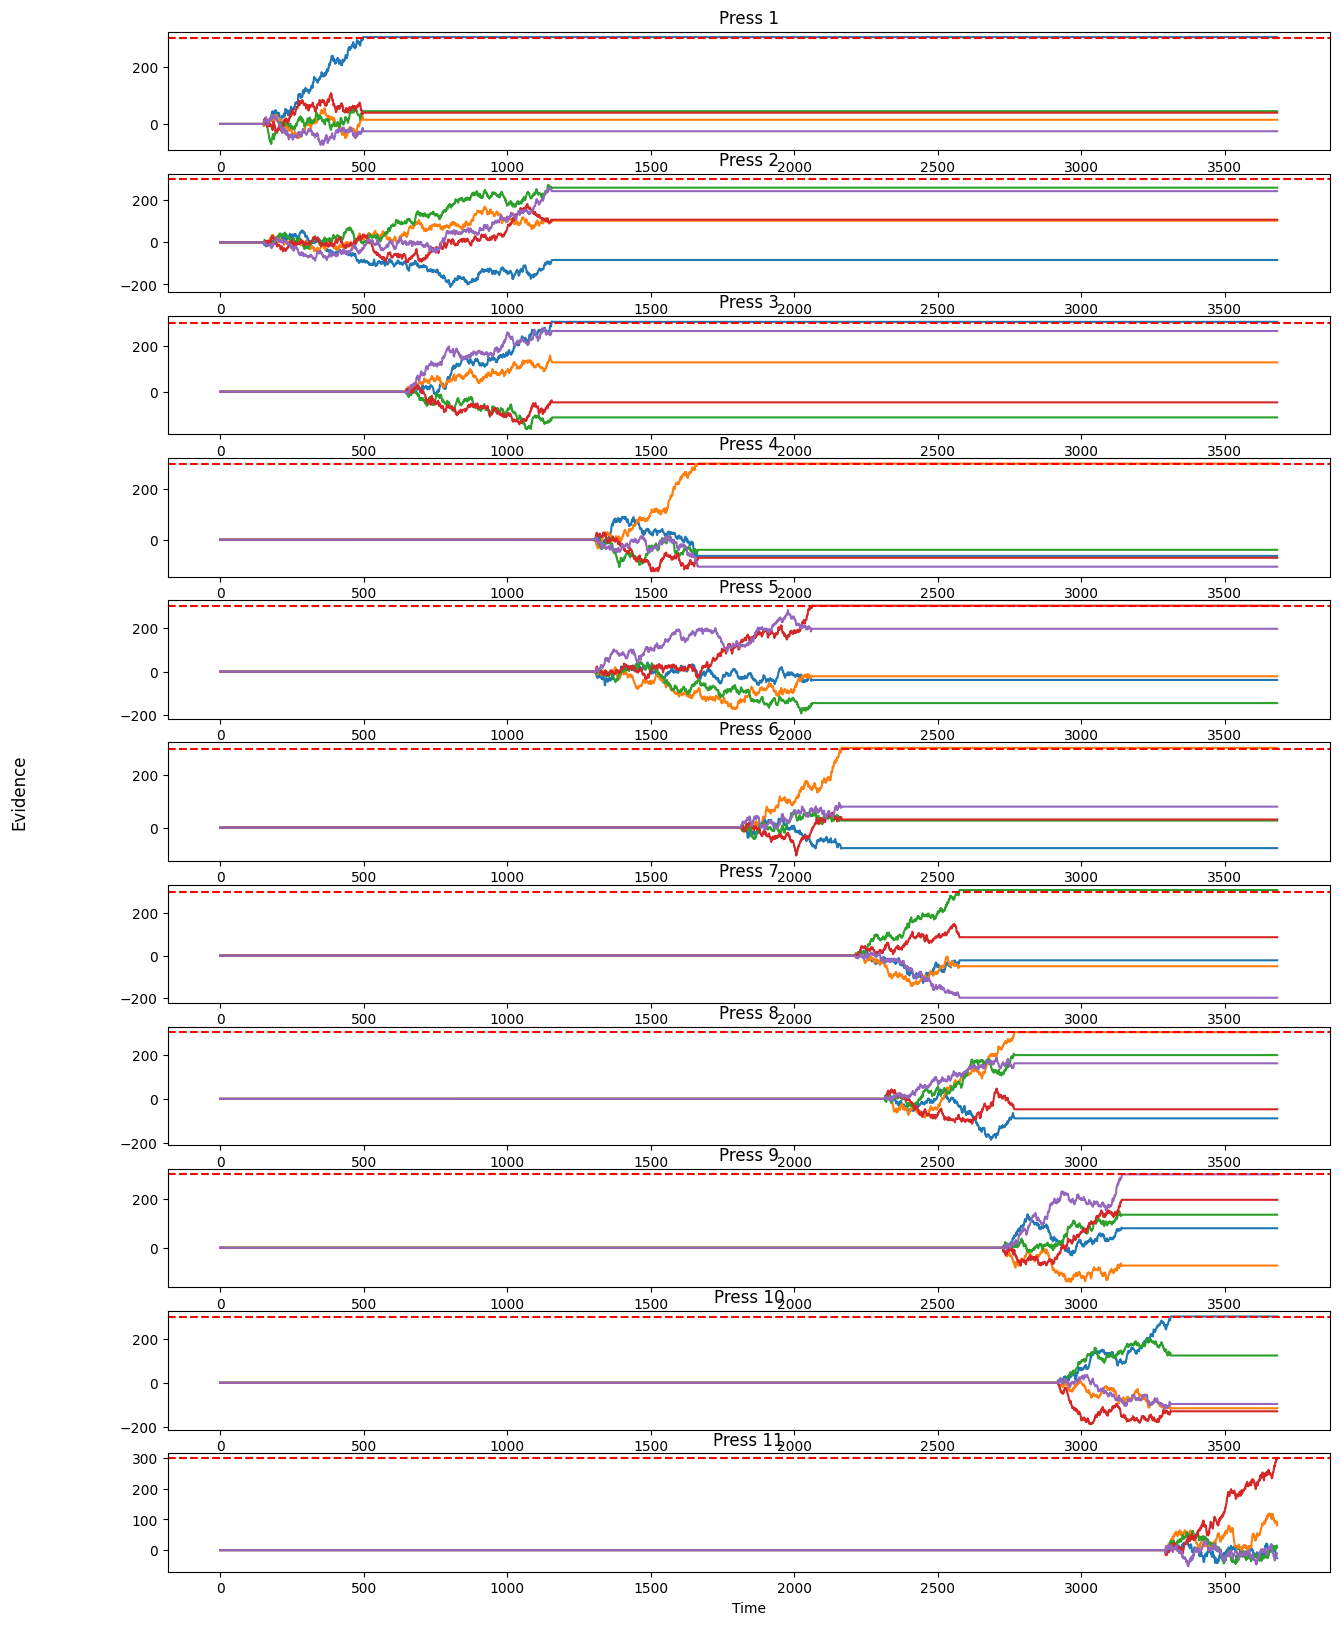

In [ ]:
model = DriftDiffusionModel(drifts, diffusion, threshold, window_size=2, visual_delay=150, planning_capacity=4, planning_param=2)
model.plot_simulations()
# model.simulate()
# model.plot_IPIs()

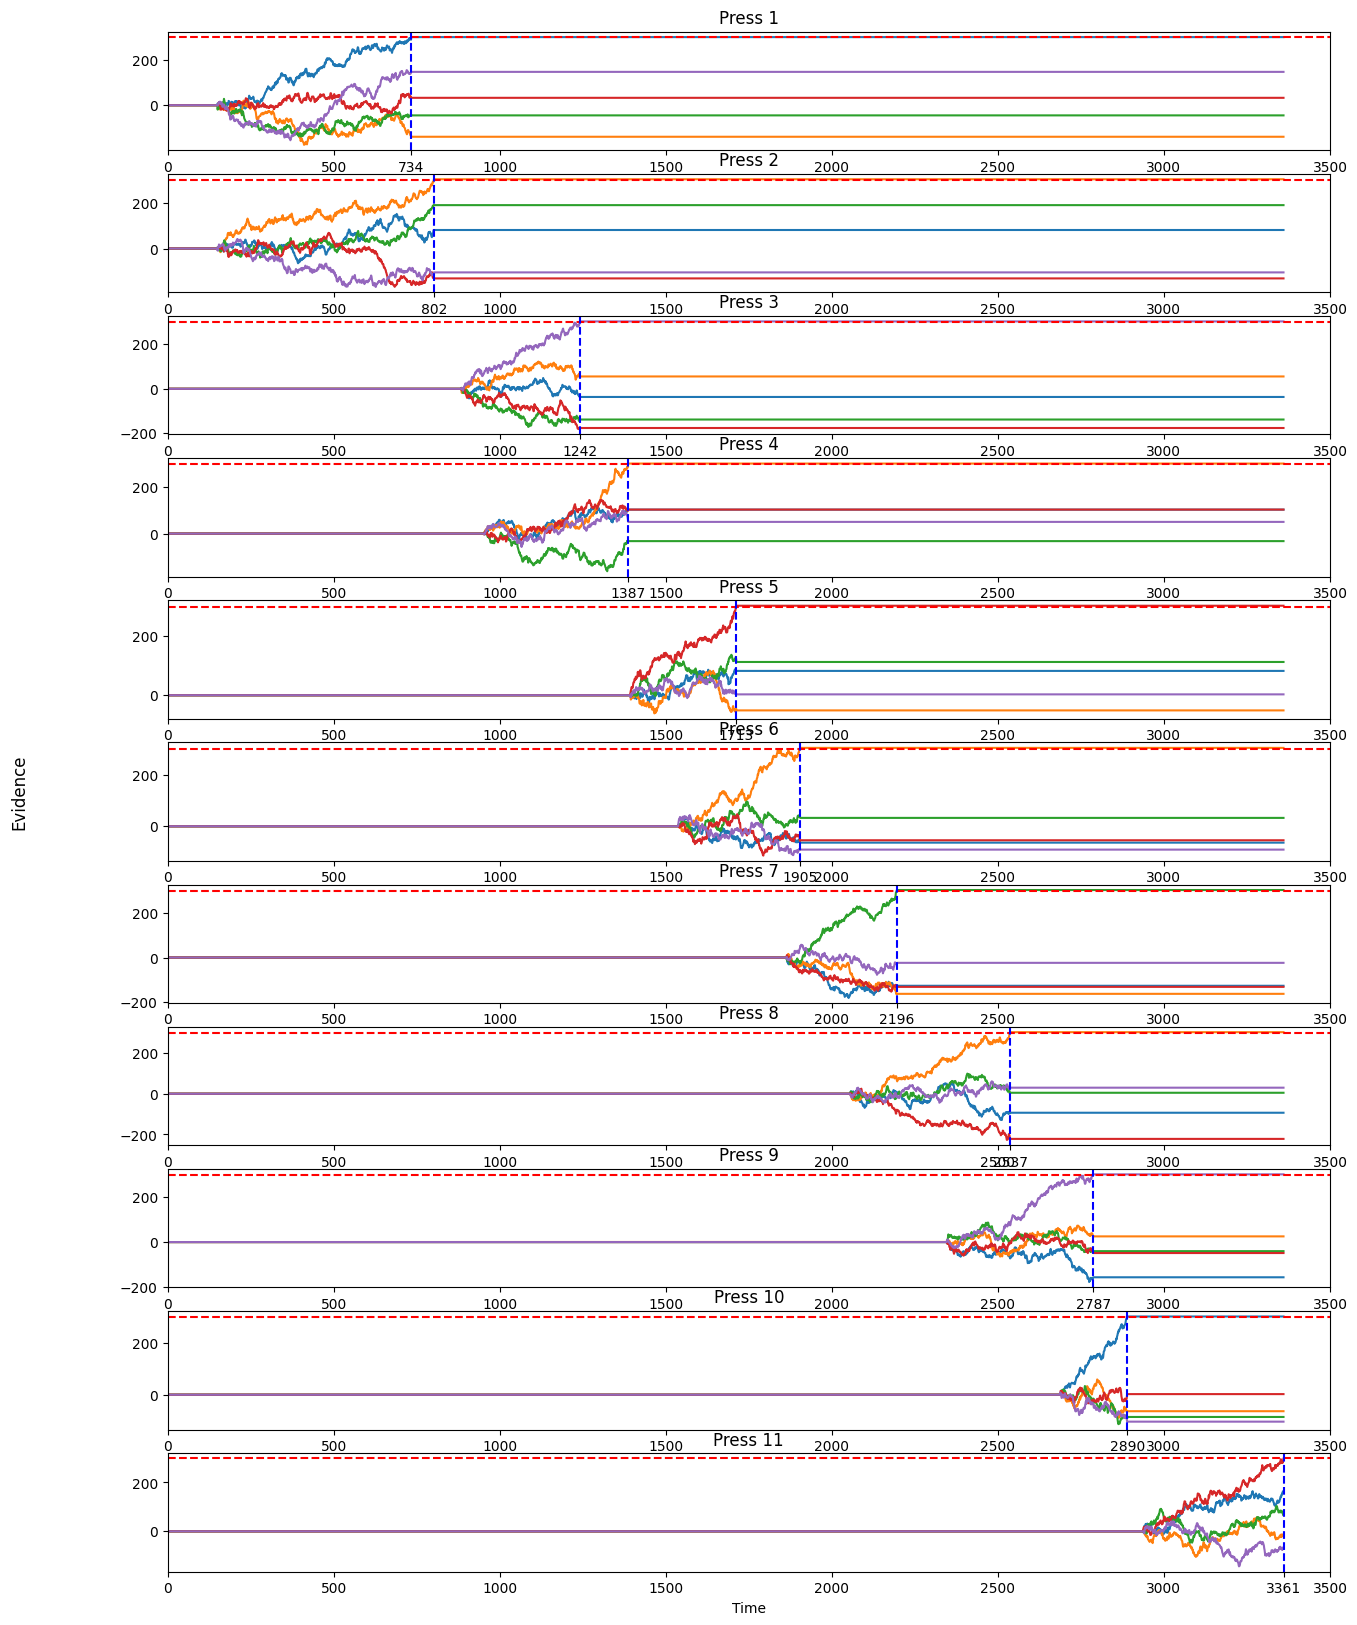

In [ ]:
model = DriftDiffusionModel_Optimzied(visual_drifts, memory_drifts, diffusion, threshold, window_size=2, visual_delay=150, planning_capacity=4, planning_param=2)
model.plot_simulations()
# model.simulate()
# model.plot_IPIs()

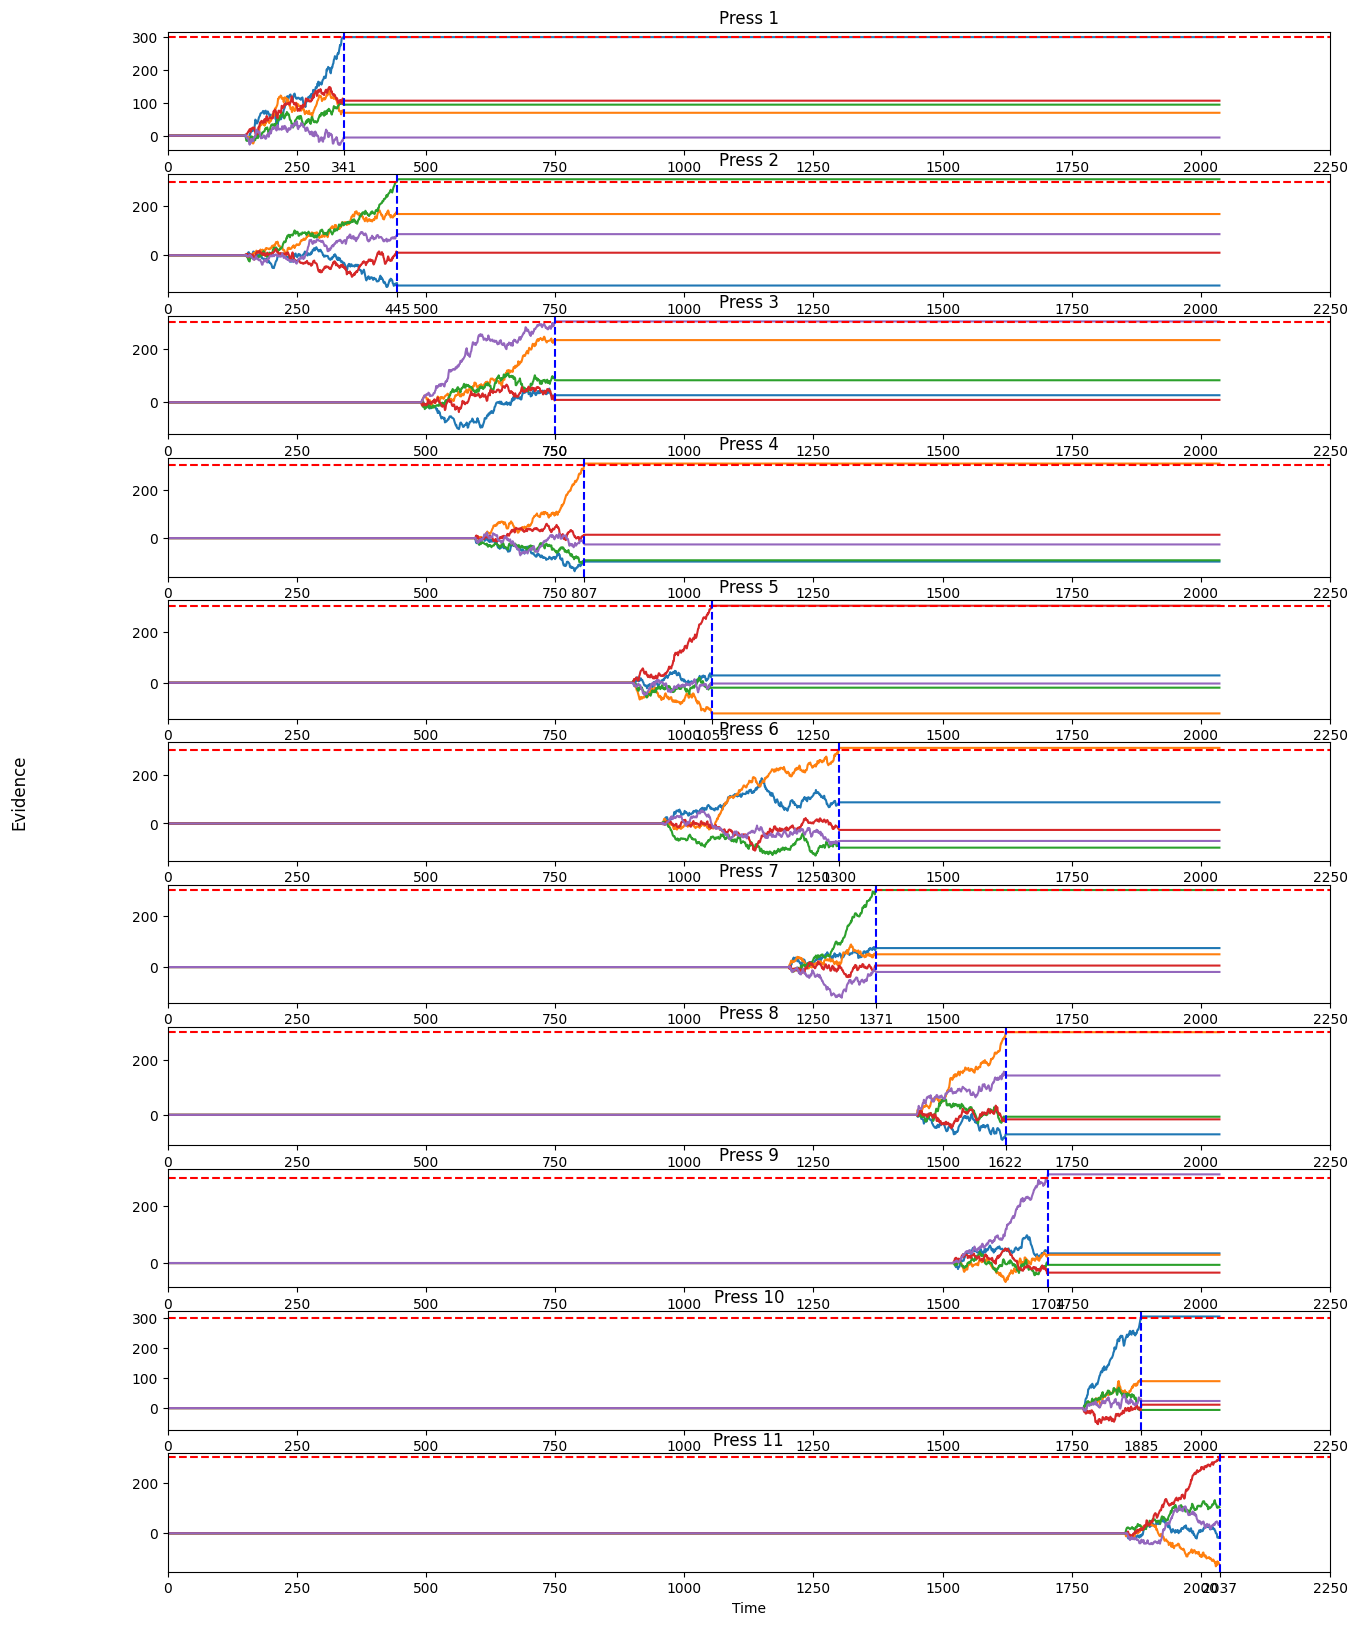

In [ ]:
model = DriftDiffusionModel_Optimzied(visual_drifts, memory_drifts, diffusion, threshold, window_size=2, visual_delay=150, planning_capacity=4, planning_param=2)
model.plot_simulations()
# model.simulate()
# model.plot_IPIs()

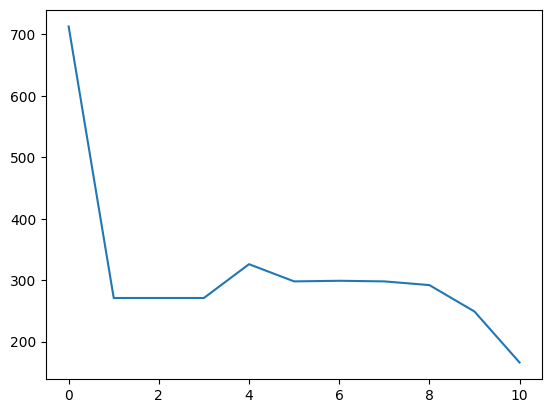

Timer unit: 1e-09 s

Total time: 0.122592 s
File: /var/folders/wg/16zn32014z5grhdv06dk49f00000gn/T/ipykernel_45128/1401399385.py
Function: simulate at line 30

Line #      Hits         Time  Per Hit   % Time  Line Contents
    30                                               def simulate(self):
    31                                                   """
    32                                                   Simulate the drift-diffusion processes until one reaches the threshold.
    33                                           
    34                                                   Returns:
    35                                                   decision_time (float): The time it took for the first process to reach the threshold.
    36                                                   winner (int): The index of the process that reached the threshold first.
    37                                                   """
    38         1       8000.0   8000.0      0.0          evidenc

In [ ]:

model = DriftDiffusionModel(drifts, diffusion = 0, threshold = threshold, visual_delay=150, window_size=4, planning_capacity=4, planning_param=2)
# model.plot_simulations()
%lprun -f model.simulate model.simulate()
model.plot_IPIs()

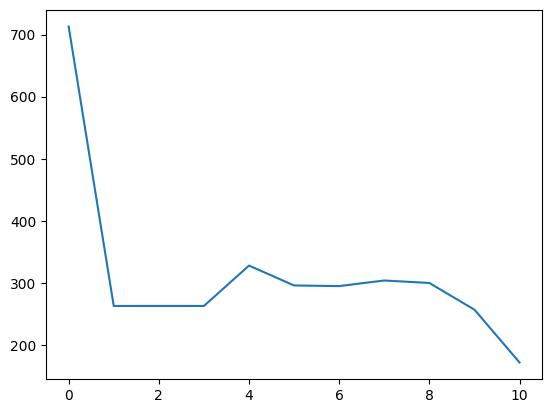

Timer unit: 1e-09 s

Total time: 0.003654 s
File: /var/folders/wg/16zn32014z5grhdv06dk49f00000gn/T/ipykernel_45128/2668952069.py
Function: simulate at line 31

Line #      Hits         Time  Per Hit   % Time  Line Contents
    31                                               def simulate(self):
    32         1    3653000.0    4e+06    100.0          press_times = simulate_ddm(self.drifts, self.diffusion, self.threshold, self.dt, self.max_time, self.seq_length, self.window_size, self.planning_capacity, self.planning_param, self.planning_strategy, self.visual_delay)
    33         1       1000.0   1000.0      0.0          self.press_times = press_times

In [ ]:

model = DriftDiffusionModel_Optimzied(drifts, diffusion = 0, threshold = threshold, visual_delay=150, window_size=4, planning_capacity=4, planning_param=2, planning_strategy=0)
# model.plot_simulations()
%lprun -f model.simulate model.simulate()
model.plot_IPIs()

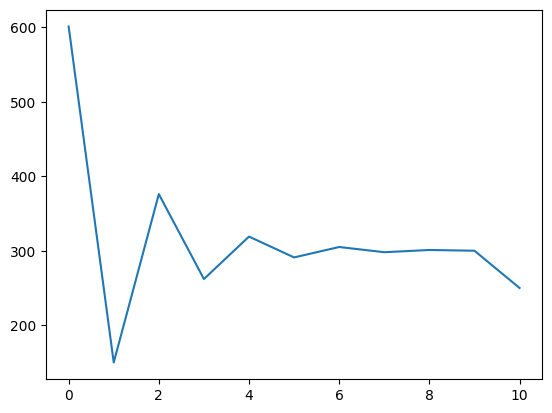

Timer unit: 1e-09 s

Total time: 0.001964 s
File: /var/folders/wg/16zn32014z5grhdv06dk49f00000gn/T/ipykernel_45221/2282306544.py
Function: simulate at line 31

Line #      Hits         Time  Per Hit   % Time  Line Contents
    31                                               def simulate(self):
    32         1    1955000.0    2e+06     99.5          press_times = simulate_ddm(self.drifts, self.diffusion, self.threshold, self.dt, self.max_time, self.seq_length, self.window_size, self.planning_capacity, self.planning_param, self.planning_strategy, self.visual_delay)
    33         1       1000.0   1000.0      0.1          self.press_times = press_times
    34         1       8000.0   8000.0      0.4          return calculate_IPI_from_press_time(self.press_times)

In [ ]:

model = DriftDiffusionModel_Optimzied(drifts, diffusion = 0, threshold = threshold, visual_delay=150, window_size=2, planning_capacity=4, planning_param=2, planning_strategy=0)
# model.plot_simulations()
%lprun -f model.simulate model.simulate()
model.plot_IPIs()

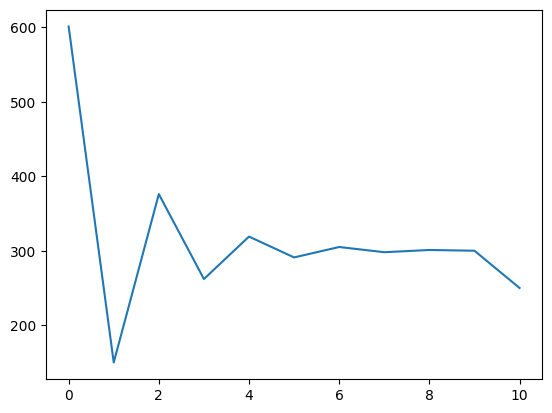

Timer unit: 1e-09 s

Total time: 0.06892 s
File: /var/folders/wg/16zn32014z5grhdv06dk49f00000gn/T/ipykernel_45221/1401399385.py
Function: simulate at line 30

Line #      Hits         Time  Per Hit   % Time  Line Contents
    30                                               def simulate(self):
    31                                                   """
    32                                                   Simulate the drift-diffusion processes until one reaches the threshold.
    33                                           
    34                                                   Returns:
    35                                                   decision_time (float): The time it took for the first process to reach the threshold.
    36                                                   winner (int): The index of the process that reached the threshold first.
    37                                                   """
    38         1      13000.0  13000.0      0.0          evidence

In [ ]:

model = DriftDiffusionModel(drifts, diffusion = 0, threshold = threshold, visual_delay=150, window_size=2, planning_capacity=4, planning_param=2)
# model.plot_simulations()
%lprun -f model.simulate model.simulate()
model.plot_IPIs()